In [15]:
%matplotlib inline 

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from keras.models import load_model

import sys
sys.path.insert(0, '../api_tutorials')
from bqsr_cnn import parse_args, read_to_bqsr_tensor, bqsr_get_metric_dict, bqsr_bed_file_to_dict, BQSR_LABELS
from bqsr_cnn import bqsr_get_train_valid_test_paths_all, bqsr_label_tensors_generator

In [4]:
sys.argv = ['bqsr_cnn']
args = parse_args()

Arguments are Namespace(activation='relu', activity_weight=1.0, annotation_set='_', annotations=[], bam_file=None, base_quality_mode='phot', batch_size=32, bed_file=None, channels_last=False, chrom=None, conv_batch_normalize=False, conv_dropout=0.0, conv_layers=[128, 96, 64, 48], conv_widths=[5, 5, 5, 5], data_dir=None, downsample_perfect_reads=0.0, end_pos=0, epochs=25, fc_batch_normalize=False, fc_dropout=0.0, fc_initializer='glorot_normal', fc_layers=[32], fps=1, id='no_id', ignore_vcf=None, input_symbol_set='dna_annotations', input_symbols={'A': 0, 'C': 1, 'G': 2, 'T': 3, 'pair': 4, 'cycle': 5, 'mq': 6}, inspect_model=False, inspect_show_labels=False, iterations=5, jitter=0.0, kernel_initializer='glorot_normal', l1=0.0, l2=0.0, label_smoothing=0.0, label_weights=[0.5, 0.5], labels={'GOOD_BASE': 0, 'BAD_BASE': 1}, learning_rate=0.01, map_input_to_logspace=False, max_pools=[], maxfun=9, mode=None, model=None, out='recalibrated.bam', output_dir='./weights/', padding='same', patience=4

In [5]:
# model_path = '/home/tsato/model/input_in_log.hd5'
model_id = 'keep-10percent-of-perfect-reads'
model_path = 'use-oq'
model_id = "weighted-cross-entropy"
model_path = '/home/tsato/model/' + model_id + "/" + model_id + ".hd5"

# args.data_dir = '/home/tsato/data/tensors/10-25-2018/'
args.data_dir = '/home/tsato/data/tensors/oq/'

map_input_to_logspace = True
label_weights = [1.0, 1.0]
model = load_model(model_path, custom_objects=bqsr_get_metric_dict(BQSR_LABELS, label_weights))

In [6]:
train_paths, valid_paths, test_paths = bqsr_get_train_valid_test_paths_all(args)

generate_train = bqsr_label_tensors_generator(args, train_paths)
generate_valid = bqsr_label_tensors_generator(args, valid_paths)
generate_test = bqsr_label_tensors_generator(args, test_paths)

def get_next_batch(generator, quality_correction):
    batch = next(generator)
    tensor = batch[0][args.tensor_name]
    label = batch[1]
    pred = model.predict_on_batch(tensor)
    pred_qscores = -10* np.log10(pred[:,:,args.labels['BAD_BASE']]) + quality_correction # +10 only if the tensor is generated with a bias

    orig_qscores = -10*np.log10(1-np.max(tensor[:,:,:4], axis=2))
    annot = tensor[:,0,(args.input_symbols['pair'], args.input_symbols['mq'])]
    
    return pred_qscores, orig_qscores, label, annot

batch shape is: (32, 151, 7)


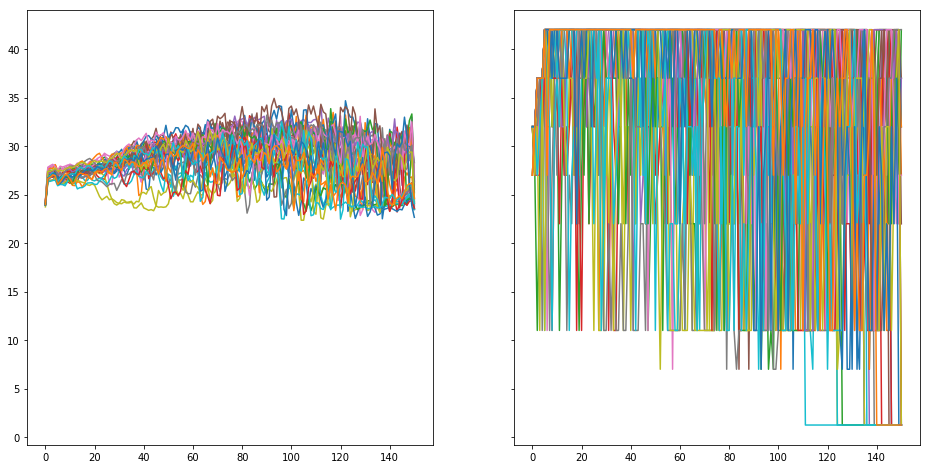

In [7]:
pred_qscores, orig_qscores, label, annot = get_next_batch(generate_train, quality_correction=20.0)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(16, 8)
ax1.plot(np.arange(args.window_size), pred_qscores.T)
ax2.plot(np.arange(args.window_size), orig_qscores.T)

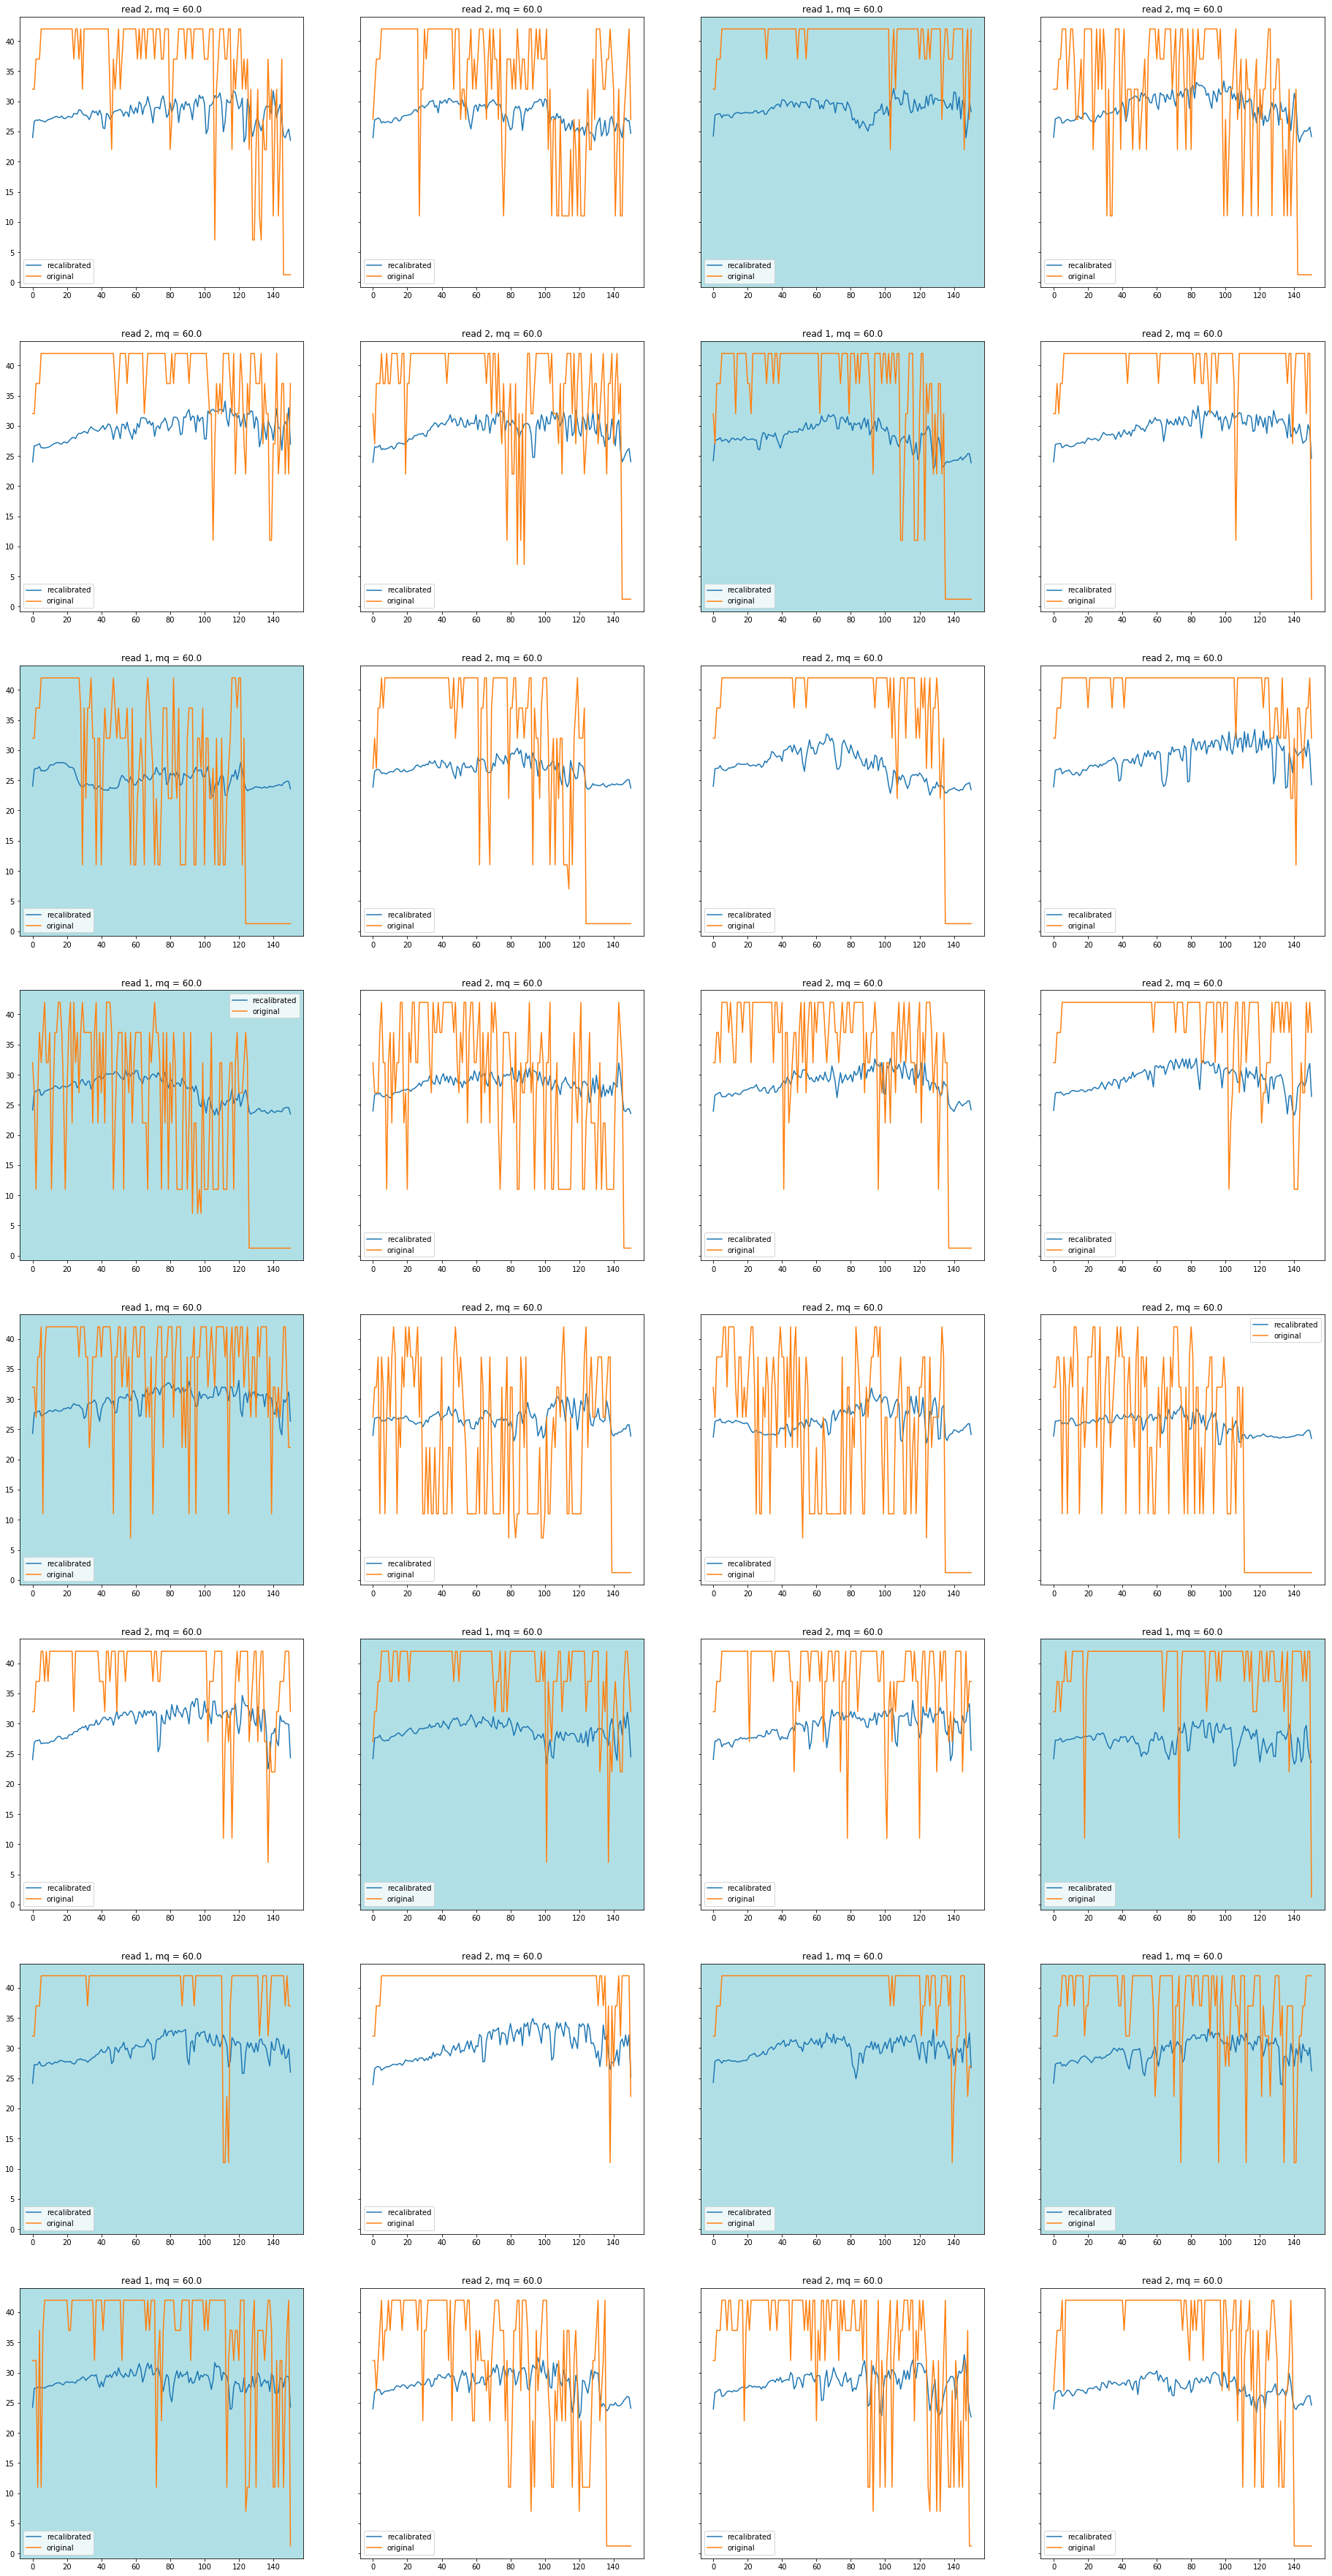

In [8]:
nrow,ncol = 8,4
fig, ax = plt.subplots(nrow, ncol, sharey=True)
fig.set_size_inches(ncol*8, nrow*8)
for i in np.arange(nrow):
    for j in np.arange(ncol):
        sample_idx = i*ncol+j
        read_num = '1' if annot[sample_idx, 0] == 1 else '2' 
        mq = annot[sample_idx, 1] * 60.0
        if (read_num == '1'):
            ax[i][j].set_facecolor('powderblue')
        ax[i][j].set_title("read " + read_num + ", mq = " + str(mq))
        ax[i][j].plot(np.arange(args.window_size), pred_qscores[sample_idx], label="recalibrated")
        ax[i][j].plot(np.arange(args.window_size), orig_qscores[sample_idx], label="original")
        ax[i][j].legend()

In [9]:
# plot the histograms of good vs bad bases
max_quality = 50
num_batches = 1000

current_match_idx = 0
current_mismatch_idx = 0
init_size = 32*151 # size of a single batch

match_qs = np.zeros(0)
mismatch_qs = np.zeros(0)
match_orig_qs = np.zeros(0)
mismatch_orig_qs = np.zeros(0)

for i in np.arange(num_batches):
    pred_qscores, orig_qscores, label, annot = get_next_batch(generate_train, quality_correction=10.0)
    
    pred = pred_qscores[:,:,np.newaxis] * label
    orig = orig_qscores[:,:,np.newaxis] * label

    match_tmp = pred[:,:,args.labels['GOOD_BASE']].flatten()
    match_qs = np.concatenate((match_qs, match_tmp[match_tmp != 0])) # remove entries that are zero
    
    mismatch_tmp = pred[:,:,args.labels['BAD_BASE']].flatten()
    mismatch_qs = np.concatenate((mismatch_qs, mismatch_tmp[mismatch_tmp != 0]))
    
    match_orig_tmp = orig[:,:,args.labels['GOOD_BASE']].flatten()
    match_orig_qs = np.concatenate((match_orig_qs, match_orig_tmp[match_orig_tmp != 0]))
    mismatch_orig_tmp = orig[:,:,args.labels['BAD_BASE']].flatten()
    mismatch_orig_qs = np.concatenate((mismatch_orig_tmp, mismatch_orig_tmp[mismatch_orig_tmp != 0]))

# TODO: must investigate why sometimes labels don't add up to 32*151...
# assert np.prod(label.shape)*num_batches == match_qs.shape[0] + mismatch_qs.shape[0]

In [10]:
print('mean of match bq = ' + str(np.mean(match_qs)))
print('std of match bq = ' + str(np.std(match_qs)))
print('mean of mismatch bq = ' + str(np.mean(mismatch_qs)))
print('std of mismatch bq = ' + str(np.std(mismatch_qs)))

mean of match bq = 18.417358264
std of match bq = 2.23417094086
mean of mismatch bq = 16.6220859258
std of mismatch bq = 2.40272949718


Text(0.5,1,'does not match reference')

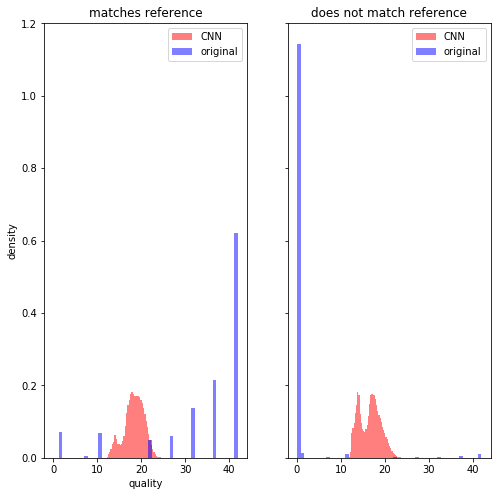

In [11]:
# normalize and plot the differences before and after the recalibration
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_size_inches(8, 8)


ax1.hist(match_qs, bins=max_quality, color="red", alpha=0.5, density=True, label="CNN")
ax1.hist(match_orig_qs, bins=max_quality, color="blue", alpha=0.5, density=True, label="original")
ax1.legend()
ax1.set_title("matches reference")
ax1.set_ylabel("density")
ax1.set_xlabel("quality")

ax2.hist(mismatch_qs, bins=max_quality, color="red", alpha=0.5, density=True, label="CNN")
ax2.hist(mismatch_orig_qs, bins=max_quality, color="blue", alpha=0.5, density=True, label="original")
ax2.legend()
ax2.set_title("does not match reference")

In [12]:
def KL_divergence(match_qs, mismatch_qs):
    ''' compute the KL divergence between the predicted qualities of bases that match the reference and those that don't
    match_qs and mismatch_qs are both arrays of qualities, unsorted and unrounded, straight out of the CNN or SAM.
    greater the KL divergence, the greater the separation between the two distributions
    '''
    # bins are half open: 1 will go in the [1,2) bin
    max_quality=50
    match_hist, match_bins = np.histogram(np.round(match_qs), bins=max_quality, range = (0,max_quality))
    mismatch_hist, mismatch_bins = np.histogram(np.round(mismatch_qs), bins=max_quality, range = (0,max_quality))

    # compute the KL divergence KL(match||mismatch) - the order chosen arbitrariliy i.e. could've easily chosen KL(mismatch||match)
    # mask bins with 0 probability mass because numpy doens't know 0*log(0)=0
    ma_match_hist = ma.array(match_hist, mask=match_hist == 0)
    ma_mismatch_hist = ma.array(mismatch_hist, mask=match_hist == 0)
    KL = -mp.sum(ma_match_hist * mp.log(ma_mismatch_hist)) - mp.sum(- ma_match_hist * mp.log(ma_match_hist))
    return KL

In [13]:
print(KL_divergence(match_qs, mismatch_qs))
print(KL_divergence(match_orig_qs, mismatch_orig_qs))

NameError: name 'mp' is not defined

In [20]:
from scipy.stats import entropy

batch = next(generate_train)
tensor = batch[0][args.tensor_name]
y_pred = model.predict(tensor)
y_true = batch[1]

# start function 
def KL_divergence(y_true, y_pred):
    # TODO: there has got to be a KL divergence metric/implementation somewhere .... use it
    # maybe scikit learn
    predicted_qs = -10*np.log10(y_pred[:,:, args.labels['BAD_BASE']])
    match_qs = (predicted_qs[:,:,np.newaxis] * y_true)[:,:, args.labels['GOOD_BASE']]
    mismatch_qs = (predicted_qs[:,:,np.newaxis] * y_true)[:,:, args.labels['BAD_BASE']]
    match_qs = match_qs[match_qs > 0]
    mismatch_qs = mismatch_qs[mismatch_qs > 0]


    # bins are half open: 1 will go in the [1,2) bin
    max_quality=50
    match_hist, match_bins = np.histogram(np.round(match_qs), bins=max_quality, range = (0,max_quality))
    mismatch_hist, mismatch_bins = np.histogram(np.round(mismatch_qs), bins=max_quality, range = (0,max_quality))

    # compute the KL divergence KL(match||mismatch) - the order chosen arbitrariliy i.e. could've easily chosen KL(mismatch||match)
    # mask bins with 0 probability mass because numpy doens't know 0*log(0)=0
    ma_match_hist = ma.array(match_hist, mask=match_hist == 0)
    ma_mismatch_hist = ma.array(mismatch_hist, mask=match_hist == 0)
    print(entropy(match_hist, mismatch_hist))
    KL = -ma.sum(ma_match_hist * ma.log(ma_mismatch_hist)) - ma.sum(- ma_match_hist * ma.log(ma_match_hist))
    print(KL)
    return KL
KL_divergence(y_true, y_pred)

inf
15032.5088112


15032.508811207194

21443.248555469196